In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import sklearn.preprocessing 
import random
import yaml
import h5py
import logging
import datetime
import os
import time

import pprint
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import torch.nn.functional as F


from load_matlab_timedata import get_data_from
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy

from torch.optim.lr_scheduler import ReduceLROnPlateau  

In [2]:
from torchviz import make_dot

In [3]:
plt.rcParams['figure.figsize'] = 20, 7.
CONFIG_FILENAME = "model_params.yaml"
# ! ls DC_motor_simulation
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
   
pprint.pprint(config)


p_net = config['network_params']

p_train = config['train_params']

p_gen = config['generator_params']

p_data = config['data_params']
need_normalize = p_data['need_normalize']

{'data_params': {'integration_step': 0.01,
                 'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/res.mat',
                 'need_normalize': True,
                 'test_size': 0.3,
                 'use_part_of_data': 1.0},
 'exp_path': 'only_batches',
 'generator_params': {'a': 0.5, 'b': 1.0, 'f_X': 'math.sin', 'f_Y': 'math.cos'},
 'is_debug': False,
 'network_params': {'dtype': 'torch.float',
                    'hidden_size': 16,
                    'input_size': 64,
                    'num_layers': 2,
                    'output_dim': 3,
                    'per_element': True,
                    'retrospective_steps': 128},
 'to_generate_data': False,
 'train_params': {'auto_loss': True,
                  'aux_loss': {'part_of_max_for_const': 0.3,
                               'scaling_order': 5,
                               'steady_state_threshold': 0.001},
                  'batch_size': 1024,
                  'core_loss': {'part_of_max_for_

In [4]:

# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']
    
# if is_debug:
#     x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X, a=p_generate['a'], b=p_generate['b'])
to_generate_data = config['to_generate_data'] 
if to_generate_data:
    p_gen = config['generator_params']
    print("Data generator params:")
    pprint.pprint(p_gen)
    a = p_gen['a']
    b = p_gen['b']
is_debug = config['is_debug']

In [112]:
p_net['retrospective_steps']

128

In [119]:
lstm_input_size

1

In [145]:
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy  # imports here for faster rerun and debug procedure

viz_batch = 1
viz_num_layers = 1
viz_hidden = 1

p_train['batch_size'] = 1
p_net['num_layers'] = 1
p_net['retrospective_steps'] = 1
model = LSTM(lstm_input_size,
#              p_net['hidden_size'],
             viz_hidden,
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

loss_fn = myLoss

# if p_train['loss_fn'] == 'mse':  
#     loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
# elif p_train['loss_fn'] == 'l1':  
#     loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

p_optim = p_train['optimizer']
wd = p_optim['weight_decay']
lr = p_optim['learning_rate']

if p_optim['optimizer'] == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

logging.info(f"Model n params: {model.get_num_params()}")
print(f"model has [{model.get_num_params()}] params")
num_epochs = p_train['num_epochs']
logging.info("Training process INITIALIZED")
optimizer

model has [22.0] params


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

using 1.0 of data
X normalized, norms: [14.99712541]
x shape (76924, 1)
x_normalized shaoe (76924, 1)


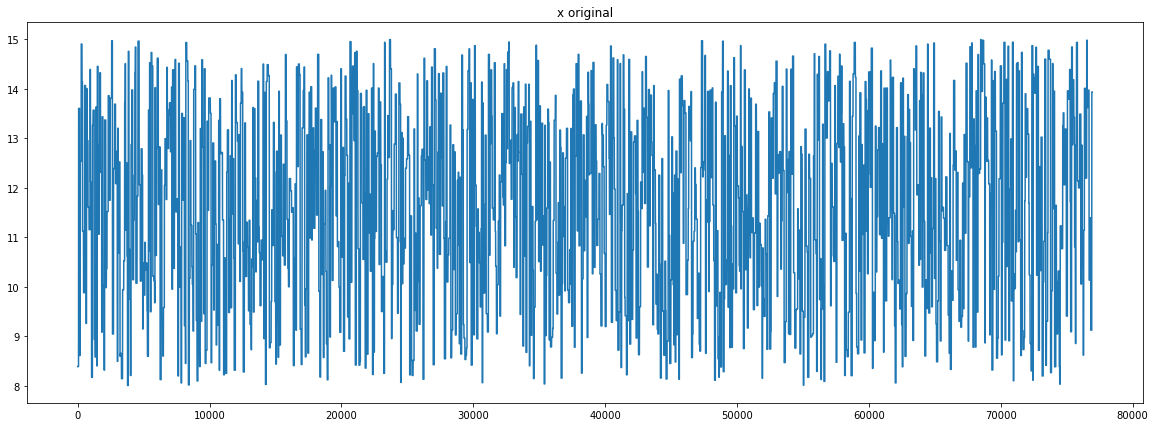

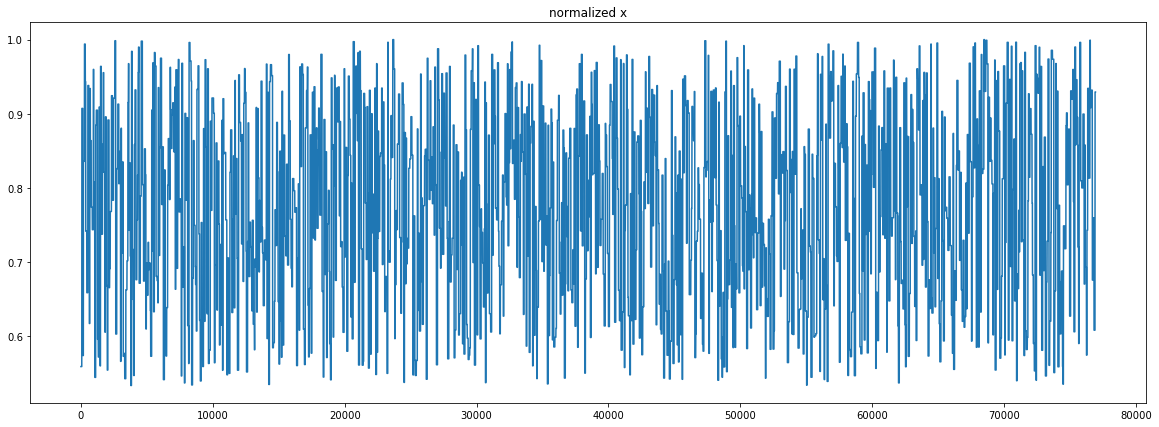

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (23078, 1)
output partition shape (23078, 1)
stacked Y shape  (23078, 1)
Y_tensor torch.Size([23078, 1])
X_tensor torch.Size([1, 23076, 1])
train set: [53719] batches
test set: [23078] batches
data_loading time 15.59091567993164 secs


In [146]:
# todo add time tracking for this cell
use_part = p_data['use_part_of_data']
print(f"using {use_part} of data")

t_tick = time.time()

test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(use_part - use_part*p_data['test_size'], use_part),                        
                               logging=logging)

print(f"train set: [{len(train_ts_ds)}] batches")
print(f"test set: [{len(test_ts_ds)}] batches")

if need_normalize:
    config['x_norm'] = train_ts_ds.x_norms[0]
    config['y_norm'] = train_ts_ds.y_norms[0]
    config['x_norm']
else:
    config['x_norm'] = 1
    config['y_norm'] = 1
    config['x_norm']

test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )    
    
t_tock = time.time()
dataload_time = t_tock - t_tick
print(f"data_loading time {dataload_time} secs")

In [147]:
for d in test_dl:
    break
x, y, index = d

In [148]:
x.shape

torch.Size([1, 1, 1])

In [149]:
test_dl

In [150]:
import hiddenlayer as hl


ModuleNotFoundError: No module named 'hiddenlayer'

In [151]:
params = []
for name, parameter in model.named_parameters():
    print(name, '\t\t', parameter.shape)

lstm.weight_ih_l0 		 torch.Size([4, 1])
lstm.weight_hh_l0 		 torch.Size([4, 1])
lstm.bias_ih_l0 		 torch.Size([4])
lstm.bias_hh_l0 		 torch.Size([4])
linear.weight 		 torch.Size([3, 1])
linear.bias 		 torch.Size([3])


In [152]:
? make_dot

In [153]:
dic = { name:param for name, param in model.named_parameters()}
dic

{'lstm.weight_ih_l0': Parameter containing:
 tensor([[ 0.8148],
         [ 0.8344],
         [-0.6739],
         [-0.7070]], requires_grad=True),
 'lstm.weight_hh_l0': Parameter containing:
 tensor([[-0.5966],
         [-0.9524],
         [-0.2989],
         [ 0.7851]], requires_grad=True),
 'lstm.bias_ih_l0': Parameter containing:
 tensor([ 0.8165, -0.0267, -0.5282, -0.6008], requires_grad=True),
 'lstm.bias_hh_l0': Parameter containing:
 tensor([ 0.2138, -0.3198, -0.2721, -0.7894], requires_grad=True),
 'linear.weight': Parameter containing:
 tensor([[-0.9875],
         [ 0.3279],
         [-0.6356]], requires_grad=True),
 'linear.bias': Parameter containing:
 tensor([-0.3730,  0.3016, -0.2402], requires_grad=True)}

In [154]:
x_batch, y_batch, indexes = d
print(x_batch.shape)
x_batch.transpose_(0, 1)
print(x_batch.shape)

torch.Size([1, 1, 1])
torch.Size([1, 1, 1])


In [155]:
batch_shape = [ 1, 1, 1]

In [156]:
input_sample = np.random.normal(size=batch_shape)

In [157]:
input_sample.shape

(1, 1, 1)

In [158]:
? np.random.normal

In [159]:
?np.random

In [160]:
x_batch.shape

torch.Size([1, 1, 1])

In [161]:
input_sample_tenz = torch.as_tensor(input_sample, dtype=torch.float32)
input_sample_tenz.shape

torch.Size([1, 1, 1])

In [162]:
x_batch.shape

torch.Size([1, 1, 1])

In [163]:
y_pred = model(input_sample_tenz )

In [164]:
y_pred

tensor([[-0.3266,  0.2862, -0.2104]], grad_fn=<AddmmBackward>)

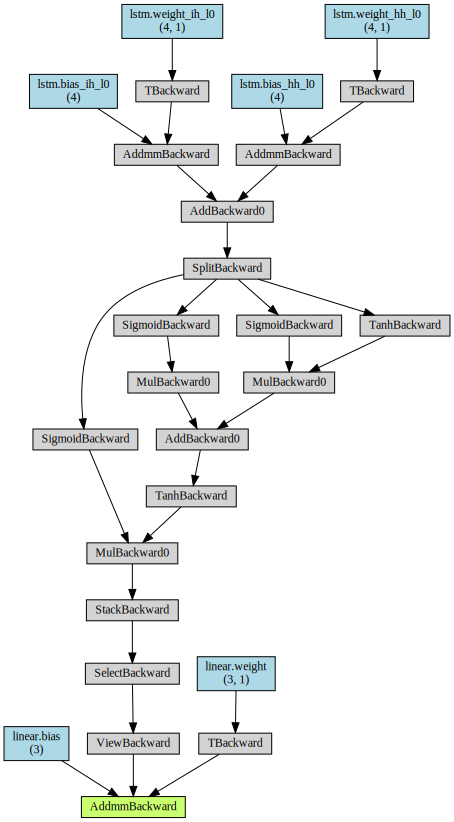

In [165]:
# make_dot(y_pred, dic)
make_dot(y_pred, dic)

In [ ]:
%matplotlib inline
from graphviz import Digraph
import re
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Variable
import torchvision.models as models


# def make_dot(var):
#     node_attr = dict(style='filled',
#                      shape='box',
#                      align='left',
#                      fontsize='12',
#                      ranksep='0.1',
#                      height='0.2')
#     dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
#     seen = set()

#     def add_nodes(var):
#         if var not in seen:
#             if isinstance(var, Variable):
#                 value = '('+(', ').join(['%d'% v for v in var.size()])+')'
#                 dot.node(str(id(var)), str(value), fillcolor='lightblue')
#             else:
#                 dot.node(str(id(var)), str(type(var).__name__))
#             seen.add(var)
#             if hasattr(var, 'previous_functions'):
#                 for u in var.previous_functions:
#                     dot.edge(str(id(u[0])), str(id(var)))
#                     add_nodes(u[0])
#     add_nodes(var.creator)
#     return dot


inputs = torch.randn(1,3,224,224)
resnet18 = models.resnet18()
y = resnet18(Variable(inputs))
print(y)

g = make_dot(y)
g